# Hyperparameter optimization

### Acknowledgments & Credits

This lesson is adapted largely from the excellent curriculum materials by Cliburn Chan (2021) at https://github.com/cliburn/bios-823-2021/ under the MIT License.

### References

- [Optuna homepage](https://optuna.org/)
- [Optuna documentation](https://optuna.readthedocs.io/)

## Prepare dataset: MNIST

In [1]:
import keras

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Define the objective

The objective is to optimize the hyperparameters of a neural network. We will use the `optuna` library to orchestrate and run the optimization _trials_ as a _study_.

Optuna expects a callable object which will be passed a `trial` object.
- The `trial` object is used to sample hyperparameters and report the objective value.
- The objective value is the value of the loss function that we are trying to minimize.

The callable object could be a function or a class with a `__call__` method. We will use a class with a `__call__` method so that we can easily store and access the data and fixed parameters.

In [3]:
import optuna

In [4]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input

In [5]:
class Objective(object):
    def __init__(self, X, y, 
                 max_epochs, 
                 input_shape, 
                 num_classes):
        self.X = X
        self.y = y
        self.max_epochs = max_epochs
        self.input_shape = input_shape
        self.num_classes = num_classes
 
    def __call__(self, trial):        
        dropout=trial.suggest_float('dropout', 0.1, 0.4, step=0.05)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 96])
        epochs = trial.suggest_int('epochs', 1, self.max_epochs, step=1)   

        params = dict(
            dropout = dropout,
            batch_size = batch_size
        )
            
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(params['dropout']))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(params['dropout']))
        model.add(Dense(self.num_classes, activation='softmax'))
            
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])                 
             
        # fit the model
        hist = model.fit(x=self.X, y=self.y,
                          batch_size=params['batch_size'],
                          validation_split=0.25,
                          epochs=epochs)
                 
        loss = np.min(hist.history['val_loss'])
                 
        return loss

In [6]:
optuna.logging.set_verbosity(0)

## Prepare and run study    

In [ ]:
N = 6
max_epochs = 3
input_shape = (28,28,1)
num_classes = 10

In [13]:
%%time

objective = Objective(X_train, y_train, max_epochs, input_shape, num_classes)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8830 - loss: 0.3825 - val_accuracy: 0.9796 - val_loss: 0.0682
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9815 - loss: 0.0623 - val_accuracy: 0.9856 - val_loss: 0.0474
Epoch 1/2
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8979 - loss: 0.3201 - val_accuracy: 0.9819 - val_loss: 0.0592
Epoch 2/2
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9831 - loss: 0.0549 - val_accuracy: 0.9836 - val_loss: 0.0534
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8827 - loss: 0.3733 - val_accuracy: 0.9833 - val_loss: 0.0546
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8821 - loss: 0.3887 - val_accuracy: 0.9819 - val_loss: 0.0613
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8913 - loss: 0.3407 - val_accuracy: 0.9757 - val_loss: 0.0818
CPU times: user 1min 12s, sys: 37.5 s, total: 1min 49s
Wall time: 1min 41s


## Inspect and visualize study results

In [9]:
df = study.trials_dataframe()

In [10]:
df.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_epochs,state
0,0,0.045355,2024-11-27 15:04:53.073742,2024-11-27 15:05:22.764830,0 days 00:00:29.691088,96,0.35,3,COMPLETE
1,1,0.067987,2024-11-27 15:05:22.764992,2024-11-27 15:05:37.271687,0 days 00:00:14.506695,64,0.15,1,COMPLETE
2,2,0.051764,2024-11-27 15:05:37.271814,2024-11-27 15:05:57.435135,0 days 00:00:20.163321,96,0.35,2,COMPLETE
3,3,0.060558,2024-11-27 15:05:57.435226,2024-11-27 15:06:08.352475,0 days 00:00:10.917249,96,0.15,1,COMPLETE
4,4,0.066759,2024-11-27 15:06:08.352579,2024-11-27 15:06:21.581514,0 days 00:00:13.228935,64,0.25,1,COMPLETE


In [11]:
from optuna.visualization.matplotlib import plot_param_importances

/var/folders/_m/95yqs0kj1xsd4l92yjkfr2hm0000gn/T/ipykernel_93478/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

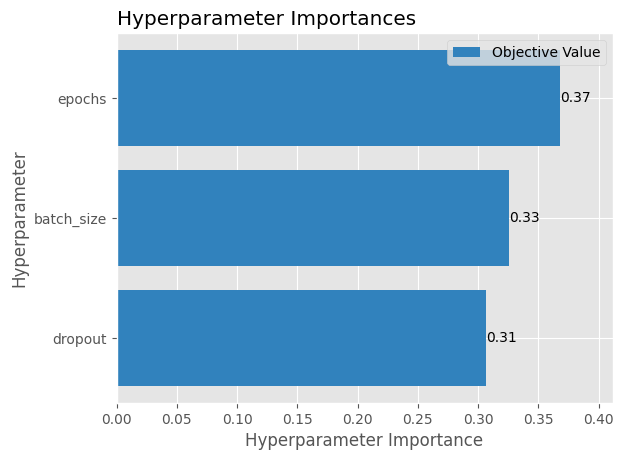

In [12]:
plot_param_importances(study)